In [1]:
from src.preprocessing.dataLoader_CelebA import get_partitioned_dataloaders, create_subset_loader
from src.ml.resNet50 import SiameseResNet
from src.ml.losses_utils import ContrastiveLoss
import torch
from src.ml.hyperparam_study import run_optuna_study

# 1. Load the data

In [2]:
IMAGE_DIR = "data/celeba/img_align_celeba"
LABEL_FILE = "data/celeba/identity_CelebA.txt"
PARTITION_FILE = "data/celeba/list_eval_partition.csv"
IMG_SIZE = 256
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_loader, val_loader, test_loader = get_partitioned_dataloaders(image_dir= IMAGE_DIR,
                                                               label_file= LABEL_FILE,
                                                               partition_file= PARTITION_FILE,
                                                               batch_size=BATCH_SIZE,
                                                               img_size=IMG_SIZE)


Label: tensor([0.])


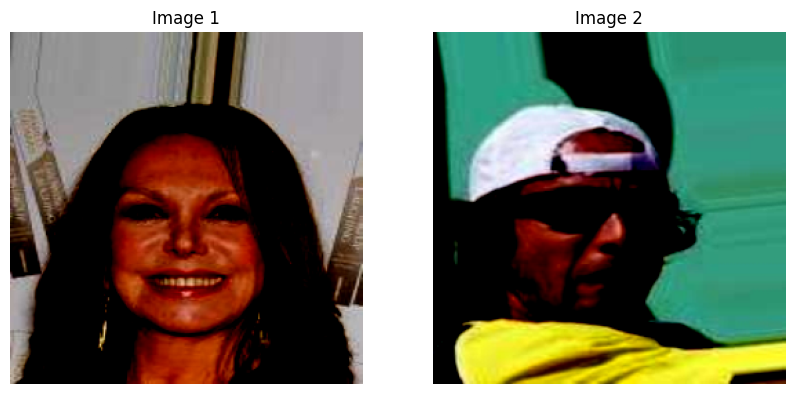

In [4]:
# Get one sample from the dataloader
dataiter = iter(test_loader)
img1, img2, label = next(dataiter)

# If you want to visualize the images, you can use matplotlib
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# For each image, we need to move the channels to the end and convert to numpy
# Assuming the images are in format (batch_size, channels, height, width)
img1_display = img1[0].permute(1, 2, 0).cpu().numpy()
img2_display = img2[0].permute(1, 2, 0).cpu().numpy()
print("\nLabel:", label[0])
# Display images
ax1.imshow(img1_display)
ax1.set_title('Image 1')
ax1.axis('off')

ax2.imshow(img2_display)
ax2.set_title('Image 2')
ax2.axis('off')

plt.show()

# Create the model

In [5]:
model = SiameseResNet()

# Find best Hyperparameters

In [11]:
train_loader_study = (create_subset_loader(train_loader,10000))
val_loader_study = (create_subset_loader(train_loader,2000))
run_optuna_study(train_loader_study, val_loader_study, n_trials=10, study_name="siamese_constrastive_HP_study")

[I 2025-05-25 16:26:23,809] Using an existing study with name 'siamese_constrastive_HP_study' instead of creating a new one.


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/5:   3%|▎         | 8/313 [00:20<13:08,  2.58s/it, loss=0.609]


[W 2025-05-25 16:26:44,990] Trial 11 failed with parameters: {'learning_rate': 3.1489116479568635e-05, 'weight_decay': 0.05669849511478857, 'margin': 7.453942447208348, 'patience': 6} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/envs/RAML/lib/python3.13/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/Users/soroureskandari/PycharmProjects/RAML/RAML25_5/src/ml/hyperparam_study.py", line 51, in <lambda>
    lambda trial: objective(trial, train_loader, val_loader),
                  ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/soroureskandari/PycharmProjects/RAML/RAML25_5/src/ml/hyperparam_study.py", line 23, in objective
    results = model.train_model_constructive(
        train_loader=train_loader,
    ...<7 lines>...
        tuning_mode=True
    )
  File "/Users/soroureskandari/PycharmProjects/RAML/RAML25_5/src/ml/resNet50.py", line 206, in train_m

KeyboardInterrupt: 

# Train Model

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [7]:
results = model.train_model_constructive(
        train_loader=create_subset_loader(train_loader,100),
        val_loader=create_subset_loader(val_loader,100),
        criterion=ContrastiveLoss(),
        optimizer=optimizer,  # Pass the created optimizer
        num_epochs=5,
        device=DEVICE,
        patience=5,
        experiment_name='SiameseResNet',
        tuning_mode=False
    )

Epoch 1/5: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Train - Loss: 0.4998, Acc: 0.5600, AUC: 0.5391


2025/05/25 16:44:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation loss decreased (inf --> 0.322957). Saving model ...
Val - Loss: 0.3230, Acc: 0.4900, AUC: 0.5165


Epoch 2/5: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Train - Loss: 0.4146, Acc: 0.4900, AUC: 0.5165
EarlyStopping counter: 1 out of 5
Val - Loss: 0.3607, Acc: 0.5500, AUC: 0.5000


Epoch 3/5: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train - Loss: 0.3197, Acc: 0.4600, AUC: 0.5000
EarlyStopping counter: 2 out of 5
Val - Loss: 0.4422, Acc: 0.5500, AUC: 0.5000


Epoch 4/5: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train - Loss: 0.3739, Acc: 0.5600, AUC: 0.5000
EarlyStopping counter: 3 out of 5
Val - Loss: 0.3974, Acc: 0.5300, AUC: 0.5000


Epoch 5/5: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train - Loss: 0.3273, Acc: 0.5100, AUC: 0.5000
EarlyStopping counter: 4 out of 5
Val - Loss: 0.3749, Acc: 0.5400, AUC: 0.5000


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Plot the results

In [ ]:
! mlflow ui --port 5000